Seismic denoising by deep learning with waveforms of natural repeating earthquakes


we present a new P-wave denoising network (PD-Net), which is trained and validated with naturally similar waveforms from global repeating earthquakes. Our approach employs a novel loss function designed to enhance waveform similarity within repetitive waveform pairs, enabling effective noise removal while preserving signal fidelity. 

In [1]:
import torch
from torchmetrics.regression import ConcordanceCorrCoef
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy import stats

import os
import json
import torch
import random
import math

import h5py
import numpy as np

from pathlib import Path
from torch.utils.data import Dataset, DataLoader
torch.use_deterministic_algorithms(True, warn_only=True)

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # 确保使用可重复的 CUDA 算法
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    os.environ["PYTHONHASHSEED"] = str(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


set_seed(12999999)
!nvidia-smi
torch.cuda.is_available()

def cc_with_offset(x, y, beg, end):
    # 确保 x 和 y 是 torch.Tensor 类型
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x).float()
    if isinstance(y, np.ndarray):
        y = torch.from_numpy(y).float()
    # 使用 unfold 提取滑动窗口
    #yy_slices = torch.stack([y[:, j+beg-200:j+end-200] for j in range(400)], dim=2) # (batch_size, 2400, 400)
    yy_slices = y.unfold(1, end-beg, 1)
    yy_slices = yy_slices.permute(0, 2, 1)
    yy_slices = yy_slices[:, :,beg-200:beg+200]  # 根据需要调整索引范围
    # 固定时间窗
    x1 = x[:, beg:end]  # Shape: (batch_size, 2400)
    # 均值
    mean_x1 = x1.mean(dim=1, keepdim=True).unsqueeze(2)  # (batch_size, 1, 1)
    mean_yy_slices = yy_slices.mean(dim=1, keepdim=True)  # (batch_size, 1, 400)
    # 协方差
    covarianceyy = torch.sum((x1.unsqueeze(2) - mean_x1) * (yy_slices - mean_yy_slices), dim=1)
    # 标准差
    std_x1 = torch.sqrt(torch.sum((x1.unsqueeze(2) - mean_x1) ** 2, dim=1))
    std_yy_slices = torch.sqrt(torch.sum((yy_slices - mean_yy_slices) ** 2, dim=1))
    # 相关系数
    correlationyy = covarianceyy / (std_x1 * std_yy_slices + 1e-8)
    # 最大相关系数及偏移量
    max_correlationyy, max_indices = torch.max(correlationyy, dim=1)
    return max_correlationyy.mean(), max_indices


Tue Dec 10 10:36:04 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.77.01              Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti     On  |   00000000:10:00.0  On |                  N/A |
|  0%   41C    P8             12W /  165W |    1379MiB /  16380MiB |     12%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from argparse import Namespace
from pathlib import Path


config = Namespace(
    train_dataset_path = Path("data/repeat_train.h5"),
    test_dataset_path = Path("data/repeat_test.h5"),
    save_path = Path("models"),
    batch_size = 4,
    valid_steps= 100,
    warmup_steps= 20000,
    save_steps= 8960,
    total_steps= 896000,
)
%pwd

'/mnt/d/workspace/01_python/022_PDNet'

In [4]:
def worker_init_fn(worker_id):
    seed = 42 + worker_id
    random.seed(seed)
    np.random.seed(seed)
class myDataset(Dataset):
    def __init__(self, path, transform=lambda x: torch.from_numpy(x).float()):
        with h5py.File(path, "r") as hdf5_file:
            self.data1 = hdf5_file["data1"][:]
            self.data2 = hdf5_file["data2"][:]

    def __len__(self):
        # Assuming all datasets are of the same length
        return len(self.data1)
    
    def __getitem__(self, index):
        dict = {
            "data1":torch.from_numpy(self.data1[index]).float(),
            "data2": torch.from_numpy(self.data2[index]).float(),
        }
        return dict
      

train_dataset = myDataset(config.train_dataset_path)
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=False, 
                          pin_memory=True, worker_init_fn=seed_worker)
train_iter = iter(train_loader)
print(next(train_iter)['data1'].shape, next(train_iter)['data2'].shape)
class myDataset_nr(Dataset):
    def __init__(self, path, transform=lambda x: torch.from_numpy(x).float()):
        with h5py.File(path, "r") as hdf5_file:
            self.data1 = hdf5_file["data1"][:]
            self.data2 = hdf5_file["data2"][:]
            self.arc = hdf5_file["arc"][:]
           

    def __len__(self):
        # Assuming all datasets are of the same length
        return len(self.data1)
    
    def __getitem__(self, index):
        dict = {
            "data1":torch.from_numpy(self.data1[index]).float(),
            "data2": torch.from_numpy(self.data2[index]).float(),
            "arc": torch.from_numpy(np.array(self.arc[index])).float(),
        }
        return dict    
class myDataset_individual(Dataset):
    def __init__(self, path, transform=lambda x: torch.from_numpy(x).float()):
        with h5py.File(path, "r") as hdf5_file:
            self.data = hdf5_file["data"][:]


    def __len__(self):
        # Assuming all datasets are of the same length
        return len(self.data)
    
    def __getitem__(self, index):
        dict = {
            "data":torch.from_numpy(self.data[index]).float(),
        }
        return dict
      


torch.Size([4, 2800]) torch.Size([4, 2800])


In [5]:
def get_dataloader(train_dataset_path, batch_size=64, shuffle=False, num_workers=1):
    train_dataset = myDataset(train_dataset_path)
    # split the dataset into train and validation
    train_size = int(0.8* len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, 
                              pin_memory=True, worker_init_fn=seed_worker)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle, 
                            pin_memory=True, worker_init_fn=seed_worker)
    return train_loader, val_loader
    

In [6]:
def model_fn(batch, model, criterion, device):
    data11 = batch["data1"].to(device)
    data22 = batch["data2"].to(device)


    f_data1 = model(data11)
    f_data2 = model(data22)   

    loss = criterion(f_data1,f_data2,data11,data22)
    return loss

In [7]:
import torch


def valid(dataloader, model, criterion, device):
    """Validate on validation set."""

    model.eval()
    running_loss = 0.0
    pbar = enumerate(dataloader)
    
    for i, batch in pbar:
            with torch.no_grad():
                loss = model_fn(batch, model, criterion, device)
                running_loss += loss.item()

    model.train()
    return running_loss / len(dataloader)

In [8]:
 # Importing necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast
from torch.utils.checkpoint import checkpoint

# Define TransformerBlock
class TransformerBlock(nn.Module):
    def __init__(self, dim, seq_len, num_heads=8, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.feed_forward = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.ReLU(),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout),
        )
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, x):
        x_res = x
        attn_output, _ = self.attention(x, x, x)
        x = self.norm1(x_res + attn_output)
        x_res = x
        x = self.feed_forward(x)
        return self.norm2(x + x_res)

# Define ResidualBlock
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(in_channels)
    
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity  # Residual connection
        return self.relu(out)

# Define SpatialAttention
class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv1d(2, 1, kernel_size=7, padding=3)  # Kernel size 7 for spatial attention
    
    def forward(self, x):
        max_out, _ = torch.max(x, dim=1, keepdim=True)  # Max pooling along channel axis
        mean_out = torch.mean(x, dim=1, keepdim=True)  # Mean pooling along channel axis
        concat_out = torch.cat((max_out, mean_out), dim=1)  # Concatenate max and mean outputs
        attention = torch.sigmoid(self.conv1(concat_out))  # Attention map
        return x * attention  # Scale input by attention map

# Define the U-Net with Transformer and attention mechanisms
class ForwardModel_unet_trans_res(nn.Module):
    def __init__(self, init_features=32, transformer_dim=256, num_heads=4):
        super(ForwardModel_unet_trans_res, self).__init__()
        
        features = init_features
        self.encoder1 = self._block(1, features, name="enc1")
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.encoder2 = self._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.encoder3 = self._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Transformer Bottleneck
        self.bottleneck_conv = nn.Conv1d(features * 4, transformer_dim, kernel_size=1)
        self.transformer = TransformerBlock(
            dim=transformer_dim, seq_len=2800 // 8, num_heads=num_heads, dropout=0.1
        )
        self.bottleneck_proj = nn.Conv1d(transformer_dim, features * 8, kernel_size=1)
        
        self.upconv3 = nn.ConvTranspose1d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = self._block(features * 4 * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose1d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = self._block(features * 2 * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose1d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = self._block(features * 2, features, name="dec1")
        
        self.conv = nn.Conv1d(in_channels=features, out_channels=1, kernel_size=1)
        self.out_bn = nn.BatchNorm1d(1)  # BatchNorm1d before Tanh
        self.tan = nn.Tanh()
    
    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        
        # Transformer Bottleneck
        bottleneck = self.bottleneck_conv(self.pool3(enc3)).permute(0, 2, 1)  # (B, C, L) -> (B, L, C)
        bottleneck = self.transformer(bottleneck)
        bottleneck = self.bottleneck_proj(bottleneck.permute(0, 2, 1))  # (B, L, C) -> (B, C, L)
        
        dec3 = self.upconv3(bottleneck)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        out = self.conv(dec1)
        out = self.out_bn(out)  # BatchNorm1d before Tanh
        out1 = self.tan(out)
        return out1.squeeze(1)  # Remove channel dimension
    
    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=features, kernel_size=3, padding=1),
            nn.BatchNorm1d(features),
            nn.ReLU(inplace=True),
            ResidualBlock(features),  # Residual Block
            SpatialAttention(),      # Spatial Attention
        )

# Model Testing
input_len = 2800
batch_size = 32
model = ForwardModel_unet_trans_res().cuda()

# Dummy input
x = torch.randn(batch_size, input_len).cuda()

# Forward pass with mixed precision
with autocast():
    output = model(x)

# Collect and display results
output_shape = output.shape
output_min = output.min().item()
output_max = output.max().item()

output_shape, output_min, output_max


(torch.Size([32, 2800]), -1.0, 1.0)

In [9]:
 # Importing necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast
from torch.utils.checkpoint import checkpoint

# Define TransformerBlock
class TransformerBlock(nn.Module):
    def __init__(self, dim, seq_len, num_heads=8, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.feed_forward = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.ReLU(),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout),
        )
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, x):
        x_res = x
        attn_output, _ = self.attention(x, x, x)
        x = self.norm1(x_res + attn_output)
        x_res = x
        x = self.feed_forward(x)
        return self.norm2(x + x_res)

# Define the U-Net with Transformer and attention mechanisms
class ForwardModel_unet_trans(nn.Module):
    def __init__(self, init_features=32, transformer_dim=256, num_heads=4):
        super(ForwardModel_unet_trans, self).__init__()
        
        features = init_features
        self.encoder1 = self._block(1, features, name="enc1")
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.encoder2 = self._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.encoder3 = self._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Transformer Bottleneck
        self.bottleneck_conv = nn.Conv1d(features * 4, transformer_dim, kernel_size=1)
        self.transformer = TransformerBlock(
            dim=transformer_dim, seq_len=2800 // 8, num_heads=num_heads, dropout=0.1
        )
        self.bottleneck_proj = nn.Conv1d(transformer_dim, features * 8, kernel_size=1)
        
        self.upconv3 = nn.ConvTranspose1d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = self._block(features * 4 * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose1d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = self._block(features * 2 * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose1d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = self._block(features * 2, features, name="dec1")
        
        self.conv = nn.Conv1d(in_channels=features, out_channels=1, kernel_size=1)
        self.out_bn = nn.BatchNorm1d(1)  # BatchNorm1d before Tanh
        self.tan = nn.Tanh()
    
    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        
        # Transformer Bottleneck
        bottleneck = self.bottleneck_conv(self.pool3(enc3)).permute(0, 2, 1)  # (B, C, L) -> (B, L, C)
        bottleneck = self.transformer(bottleneck)
        bottleneck = self.bottleneck_proj(bottleneck.permute(0, 2, 1))  # (B, L, C) -> (B, C, L)
        
        dec3 = self.upconv3(bottleneck)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        out = self.conv(dec1)
        out = self.out_bn(out)  # BatchNorm1d before Tanh
        out1 = self.tan(out)
        return out1.squeeze(1)  # Remove channel dimension
    
    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=features, kernel_size=3, padding=1),
            nn.BatchNorm1d(features),
            nn.ReLU(inplace=True),
        )

# Model Testing
input_len = 2800
batch_size = 32
model = ForwardModel_unet_trans_res().cuda()

# Dummy input
x = torch.randn(batch_size, input_len).cuda()

# Forward pass with mixed precision
with autocast():
    output = model(x)

# Collect and display results
output_shape = output.shape
output_min = output.min().item()
output_max = output.max().item()

output_shape, output_min, output_max

(torch.Size([32, 2800]), -1.0, 1.0)

In [10]:
def id_cc(x, beg, end):
    # Calculate noise energy (sum of squares over all columns)
    noise_energy = torch.sum(x[:, :1400] ** 2, dim=1) / 1400 + 1e-8

    # Calculate signal energy within the range [beg, end)
    signal_energy = torch.sum(x[:, beg:end] ** 2, dim=1) / (end - beg) 

    # Compute the ratio and apply the formula
    ratio = signal_energy / noise_energy
    rr = torch.abs((ratio - 1) / ratio)
    ideal_cc = torch.sqrt(rr)
    return torch.clamp(ideal_cc, min=0.5, max=1.0)

    
x = torch.rand(10, 2800).cuda()  # Example tensor on GPU
beg, end = 1200, 2600
rr = id_cc(x, beg, end)
print(rr.shape)

class My_loss(nn.Module):
    def __init__(self, log_interval):
        super().__init__()
        self.global_step = 0  # 全局步数
        self.log_interval = log_interval  # 控制日志输出间隔
        self.w1 = 0

    def forward(self, x, y, xx, yy):
        # Batch size and sequence length
        self.global_step += 1
        batch_size = x.size(0)
                
        wd1_beg = 1600
        wd1_end = 2600
        
        wd2_beg = 1600
        wd2_end = 2600
        alpha = 1.0

        # CC[f(r1),f(r2)] : long time window (wd1)
        x1 = x[:, wd1_beg:wd1_end]  # Shape: (batch_size, 2400)
        # Create a tensor of y slices for all samples in the batch, shape: (batch_size, 2400, 400)
        y_slices = torch.stack([y[:, j+1400:2400+j] for j in range(400)], dim=2)  # (batch_size, 2400, 400)
        # Repeat x1 along the third dimension to match y_slices, shape: (batch_size, 2400, 400)
        x1_repeated = x1.unsqueeze(2).repeat(1, 1, 400)
        # Compute means along the first dimension (2400) for each sample and slice
        mean_x1 = x1_repeated.mean(dim=1, keepdim=True)  # Shape: (batch_size, 1, 400)
        mean_y_slices = y_slices.mean(dim=1, keepdim=True)  # Shape: (batch_size, 1, 400)
        # Compute covariance and standard deviations along the first dimension (2400)
        covariance = torch.sum((x1_repeated - mean_x1) * (y_slices - mean_y_slices), dim=1)  # (batch_size, 400)
        std_x1 = torch.sqrt(torch.sum((x1_repeated - mean_x1) ** 2, dim=1))  # (batch_size, 400)
        std_y_slices = torch.sqrt(torch.sum((y_slices - mean_y_slices) ** 2, dim=1))  # (batch_size, 400)
        # Compute correlation coefficients with a small epsilon for stability
        correlation = covariance / (std_x1 * std_y_slices + 1e-8)  # Shape: (batch_size, 400)
        # Find the maximum correlation for each sample in the batch
        max_correlation = torch.max(correlation, dim=1).values  # Shape: (batch_size,)
        # Calculate the loss as 1 - max_correlation for each sample, then average over the batch
        loss0 = -alpha * torch.mean(max_correlation) + (1 - alpha) * torch.mean(( 1 - max_correlation) ** 2 )

        x_s = x[:,wd2_beg:wd2_end]
        xx_s = xx[:,wd2_beg:wd2_end]
        mean_x = torch.mean(x_s, dim=1, keepdim=True).repeat(1, wd2_end-wd2_beg)  # Shape: (batch_size, 1)
        mean_xx = torch.mean(xx_s, dim=1, keepdim=True).repeat(1, wd2_end-wd2_beg)  # Shape: (batch_size, 1)
        #print("mean_x.shape",mean_x.shape)
        # Calculate the covariance between x and xx
        covariance_x = torch.sum((x_s - mean_x) * (xx_s - mean_xx), dim=1)
        # Calculate the standard deviations
        std_x = torch.sqrt(torch.sum((x_s - mean_x)**2, dim=1))
        std_xx = torch.sqrt(torch.sum((xx_s - mean_xx)**2, dim=1))
        # Calculate the correlation
        correlation_x = covariance_x / (std_x * std_xx + 1e-8)  # Add a small epsilon to avoid division by zero
        ideal_cc = id_cc(xx, wd2_beg, wd2_end)
        loss1 = alpha * torch.mean(torch.abs(ideal_cc - correlation_x)) + (1 - alpha) * torch.mean(torch.abs(ideal_cc - correlation_x)**2)
            
        y_s = y[:,wd2_beg:wd2_end]
        yy_s = yy[:,wd2_beg:wd2_end]
        mean_y = torch.mean(y_s, dim=1, keepdim=True).repeat(1, wd2_end-wd2_beg)  # Shape: (batch_size, 1)
        mean_yy = torch.mean(yy_s, dim=1, keepdim=True).repeat(1, wd2_end-wd2_beg)  # Shape: (batch_size, 1)
        # Calculate the covariance between y and yy
        covariance_y = torch.sum((y_s - mean_y) * (yy_s - mean_yy), dim=1)
        # Calculate the standard deviations
        std_y = torch.sqrt(torch.sum((y_s - mean_y)**2, dim=1))
        std_yy = torch.sqrt(torch.sum((yy_s - mean_yy)**2, dim=1))
        # Calculate the correlation
        correlation_y = covariance_y / (std_y * std_yy + 1e-8)  # Add a small epsilon to avoid division by zero
        ideal_cc = id_cc(yy, wd2_beg, wd2_end)
        loss2 = alpha * torch.mean(torch.abs(ideal_cc - correlation_y)) + (1 - alpha) * torch.mean(torch.abs(ideal_cc - correlation_y)**2)

        # CC[f(r1),r2]
        x1 = x[:, wd1_beg:wd1_end]  # Shape: (batch_size, 2400)
        yy_slices = torch.stack([yy[:, j+1400:2400+j] for j in range(400)], dim=2)  # (batch_size, 2400, 400)
        x1_repeated = x1.unsqueeze(2).repeat(1, 1, 400)
        mean_x1 = x1_repeated.mean(dim=1, keepdim=True)  # Shape: (batch_size, 1, 400)
        mean_yy_slices = yy_slices.mean(dim=1, keepdim=True)  # Shape: (batch_size, 1, 400)
        covarianceyy = torch.sum((x1_repeated - mean_x1) * (yy_slices - mean_yy_slices), dim=1)  # (batch_size, 400)
        std_x1 = torch.sqrt(torch.sum((x1_repeated - mean_x1) ** 2, dim=1))  # (batch_size, 400)
        std_yy_slices = torch.sqrt(torch.sum((yy_slices - mean_yy_slices) ** 2, dim=1))  # (batch_size, 400)
        correlationyy = covarianceyy / (std_x1 * std_yy_slices + 1e-8)  # Shape: (batch_size, 400)
        max_correlationyy = torch.max(correlationyy, dim=1).values  # Shape: (batch_size,)
        ideal_cc = id_cc(yy, wd2_beg, wd2_end)
        loss3 = alpha * torch.mean(torch.abs(ideal_cc - max_correlationyy)) + (1 - alpha) * torch.mean(torch.abs(ideal_cc - max_correlationyy)**2)

        # CC[r1,f(r2)]
        y1 = y[:, wd1_beg:wd1_end]  # Shape: (batch_size, 2400)
        xx_slices = torch.stack([xx[:, j+1400:2400+j] for j in range(400)], dim=2)  # (batch_size, 2400, 400)
        y1_repeated = y1.unsqueeze(2).repeat(1, 1, 400)
        mean_y1 = y1_repeated.mean(dim=1, keepdim=True)  # Shape: (batch_size, 1, 400)
        mean_xx_slices = xx_slices.mean(dim=1, keepdim=True)  # Shape: (batch_size, 1, 400)
        covariancexx = torch.sum((y1_repeated - mean_y1) * (xx_slices - mean_xx_slices), dim=1)  # (batch_size, 400)
        std_y1 = torch.sqrt(torch.sum((y1_repeated - mean_y1) ** 2, dim=1))  # (batch_size, 400)
        std_xx_slices = torch.sqrt(torch.sum((xx_slices - mean_xx_slices) ** 2, dim=1))  # (batch_size, 400)
        correlationxx = covariancexx / (std_y1 * std_xx_slices + 1e-8)  # Shape: (batch_size, 400)
        max_correlationxx = torch.max(correlationxx, dim=1).values  # Shape: (batch_size,)
        ideal_cc = id_cc(xx, wd2_beg, wd2_end)
        loss4 = alpha * torch.mean(torch.abs(ideal_cc - max_correlationxx)) + (1 - alpha) * torch.mean(torch.abs(ideal_cc - max_correlationxx)**2)
            

        
        loss5 = (x[:,0:1400] ** 2).mean(dim=1).mean()
        loss6 = (y[:,0:1400] ** 2).mean(dim=1).mean()
        

        xx1 = xx[:,:1400]-x[:,:1400]
        xx2 = xx[:,1400:]-x[:,1400:]
        prob_xx1 = F.softmax(xx1, dim=1)
        prob_xx2 = F.softmax(xx2, dim=1)
        mean_dist_x = 0.5 * (prob_xx1 + prob_xx2)
        kl_first_x = F.kl_div(prob_xx1.log(), mean_dist_x, reduction="batchmean")
        kl_second_x = F.kl_div(prob_xx2.log(), mean_dist_x, reduction="batchmean")
        js_loss_x = 0.5 * (kl_first_x + kl_second_x)
        
        yy1 = yy[:,:1400]-y[:,:1400]
        yy2 = yy[:,1400:]-y[:,1400:]
        prob_yy1 = F.softmax(yy1, dim=1)
        prob_yy2 = F.softmax(yy2, dim=1)
        mean_dist_y = 0.5 * (prob_yy1 + prob_yy2)
        kl_first_y = F.kl_div(prob_yy1.log(), mean_dist_y, reduction="batchmean")
        kl_second_y = F.kl_div(prob_yy2.log(), mean_dist_y, reduction="batchmean")
        js_loss_y = 0.5 * (kl_first_y + kl_second_y)

        loss_sum = 0.3 * loss0 + 0.1 * (loss1 + loss2) / 2 + 0.3 * (loss3 + loss4) / 2  + 0.2 * (loss5 + loss6) / 2 + 0.1 * (js_loss_y + js_loss_x) / 2
        #loss0:f(r1),f(r2)  loss1+loss2:f(r1),r1;f(r2),r2  loss3+loss4:f(r1),r2;f(r2),r1
        #loss5 + loss6: first part without signal 
        return loss_sum

torch.Size([10])


In [11]:
from tqdm.notebook import tqdm
import os
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
# 清空 GPU 缓存
torch.cuda.empty_cache()

def initialize_weights(model):
    for layer in model.modules():
        if isinstance(layer, torch.nn.Linear) or isinstance(layer, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(layer.weight)  # Xavier 初始化
            if layer.bias is not None:
                torch.nn.init.constant_(layer.bias, 0)  # 将 bias 初始化为 0
        elif isinstance(layer, torch.nn.BatchNorm2d):
            torch.nn.init.constant_(layer.weight, 1)  # BatchNorm 权重初始化为1
            torch.nn.init.constant_(layer.bias, 0)  # 偏置初始化为0

def main(
	train_dataset_path,
	save_path,
	batch_size,
	valid_steps,
	warmup_steps,
	save_steps,
	total_steps,
):
	"""Main function."""
	device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
	print(f"[Info]: Use {device} now!")
	#device = "cpu"

	train_loader, valid_loader = get_dataloader(train_dataset_path, batch_size, shuffle=False)
	train_iterator = iter(train_loader)
	torch.set_num_threads(1)

	print(f"[Info]: Finish loading data!",flush = True)

	#forward_model = ForwardModel_vit(image_width, patch_height, patch_width, num_classes, dim).to(device)
	forward_model = ForwardModel_unet_trans_res().to(device)
	initialize_weights(forward_model)
    
	criterion = My_loss(log_interval=config.valid_steps)
	f_optimizer = AdamW(forward_model.parameters(), lr=1.0e-4)
	#scaler = GradScaler()
	#f_scheduler = get_cosine_schedule_with_warmup(f_optimizer, warmup_steps, total_steps)
	scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(f_optimizer, 'min', factor=0.5, patience=valid_steps, verbose=1, eps=1e-08)
	print(f"[Info]: Finish creating model!",flush = True)

	best_loss = 10000.0
	writer = SummaryWriter(log_dir="logs")

	loss_list = []
	best_state_dict = None
	pbar = tqdm(range(total_steps), total=total_steps, desc="Train loop", unit=" step")
	for step in pbar:
		# Get data
		try:
			batch = next(train_iterator)
		except StopIteration:
			train_iterator = iter(train_loader)
			batch = next(train_iterator)		

		
        # Forward model
		data1 = batch["data1"].to(device)
		data2 = batch["data2"].to(device)


		f_optimizer.zero_grad()
		
		# Forward pass with mixed precision
		with autocast():
			f_data1 = forward_model(data1)
			f_data2 = forward_model(data2)
		forward_loss = criterion(f_data1, f_data2, data1, data2)		
		forward_loss.backward()
		torch.nn.utils.clip_grad_norm_(forward_model.parameters(), max_norm=1.0)
		f_optimizer.step()
        
		
		if step <= valid_steps:
			scheduler.step(forward_loss)
		if step > valid_steps:
			scheduler.step(valid_loss)
		'''
		if step <= warmup_steps:
			f_scheduler.step()
		if step > warmup_steps:
			scheduler.step(valid_loss)
        '''
		

		# Log
		pbar.set_postfix(
			loss=f"{forward_loss.item():.5f}",
		)
#		pbar.write(f"Train_loss[{step:d}]: {forward_loss:.6f},Lr:{f_optimizer.param_groups[0]['lr']:.8f})")

		# Do validation
		if (step + 1) % valid_steps == 0:
			valid_loss = valid(valid_loader, forward_model, criterion, device)
			writer.add_scalar("valid_loss", valid_loss, step)
			
			# keep the best model
			if valid_loss < best_loss:
				best_loss = valid_loss
				best_state_dict = forward_model.state_dict()
				if step >= valid_steps : os.remove(save_path / n)
				torch.save({'model': forward_model.state_dict()}, save_path / f"model_{step+1}.pth")
				n = f"model_{step+1}.pth"

        

			loss_list.append([step, forward_loss.item(), valid_loss])
			

		# Save the best model so far.
		if (step + 1) % save_steps == 0 and best_state_dict is not None:
			pbar.write(f"save model: {step + 1}(best:{best_loss:.6f}, valid: {valid_loss:.6f},train_loss:{forward_loss:.6f},Lr:{f_optimizer.param_groups[0]['lr']:.8f})")
			pbar.write("\n")
	loss_list = np.array(loss_list)
	np.save("logs/loss/duo_loss.npy", loss_list)
	writer.close()



args = config
main(
	args.train_dataset_path,
	save_path=args.save_path,
	batch_size=args.batch_size,
	valid_steps=args.valid_steps,
	warmup_steps=args.warmup_steps,
	save_steps=args.save_steps,
	total_steps=args.total_steps,
)

[Info]: Use cuda now!
[Info]: Finish loading data!
[Info]: Finish creating model!


/home/hubery/miniconda3/envs/torch/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Train loop:   0%|          | 0/896000 [00:00<?, ? step/s]

KeyboardInterrupt: 

F:\app\anaconda\envs\pytorch\Lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
F:\app\anaconda\envs\pytorch\Lib\site-packages\torch\nn\modules\activation.py:1221: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-rep

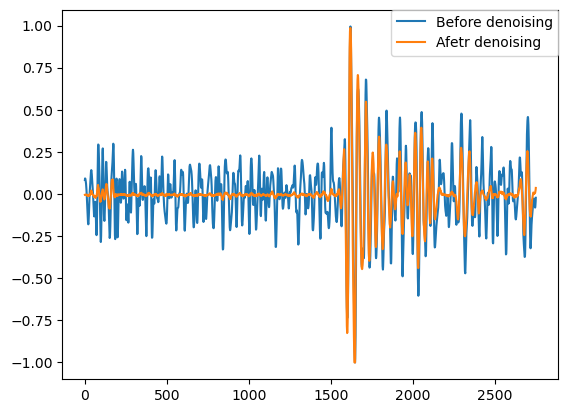

Before denoised SNR= 4.769883533231295
After denoised SNR= 12.367393107966802
CC = tensor([0.9323])


KeyboardInterrupt: 

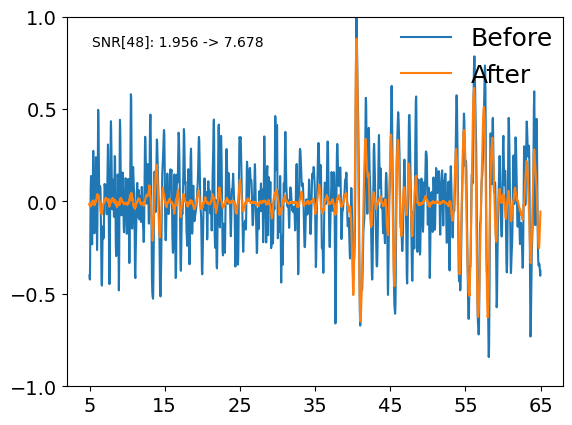

In [21]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import numpy as np

def cc_with_offset(x, y, beg, end):
    # 确保 x 和 y 是 torch.Tensor 类型
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x).float()
    if isinstance(y, np.ndarray):
        y = torch.from_numpy(y).float()
    # 使用 unfold 提取滑动窗口
    #yy_slices = torch.stack([y[:, j+beg-200:j+end-200] for j in range(400)], dim=2) # (batch_size, 2400, 400)
    yy_slices = y.unfold(1, end-beg, 1)
    yy_slices = yy_slices.permute(0, 2, 1)
    yy_slices = yy_slices[:, :,beg-200:beg+200]  # 根据需要调整索引范围
    # 固定时间窗
    x1 = x[:, beg:end]  # Shape: (batch_size, 2400)
    # 均值
    mean_x1 = x1.mean(dim=1, keepdim=True).unsqueeze(2)  # (batch_size, 1, 1)
    mean_yy_slices = yy_slices.mean(dim=1, keepdim=True)  # (batch_size, 1, 400)
    # 协方差
    covarianceyy = torch.sum((x1.unsqueeze(2) - mean_x1) * (yy_slices - mean_yy_slices), dim=1)
    # 标准差
    std_x1 = torch.sqrt(torch.sum((x1.unsqueeze(2) - mean_x1) ** 2, dim=1))
    std_yy_slices = torch.sqrt(torch.sum((yy_slices - mean_yy_slices) ** 2, dim=1))
    # 相关系数
    correlationyy = covarianceyy / (std_x1 * std_yy_slices + 1e-8)
    # 最大相关系数及偏移量
    max_correlationyy, max_indices = torch.max(correlationyy, dim=1)
    return max_correlationyy.mean(), max_indices
def cc(x, y, beg, end):
    # 确保 x 和 y 是 torch.Tensor 类型
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x).float()
    if isinstance(y, np.ndarray):
        y = torch.from_numpy(y).float()
    # 使用 unfold 提取滑动窗口
    #yy_slices = torch.stack([y[:, j+beg-200:j+end-200] for j in range(400)], dim=2) # (batch_size, 2400, 400)
    yy_slices = y.unfold(1, end-beg, 1)
    yy_slices = yy_slices.permute(0, 2, 1)
    yy_slices = yy_slices[:, :,beg-200:beg+200]  # 根据需要调整索引范围
    # 固定时间窗
    x1 = x[:, beg:end]  # Shape: (batch_size, 2400)
    # 均值
    mean_x1 = x1.mean(dim=1, keepdim=True).unsqueeze(2)  # (batch_size, 1, 1)
    mean_yy_slices = yy_slices.mean(dim=1, keepdim=True)  # (batch_size, 1, 400)
    # 协方差
    covarianceyy = torch.sum((x1.unsqueeze(2) - mean_x1) * (yy_slices - mean_yy_slices), dim=1)
    # 标准差
    std_x1 = torch.sqrt(torch.sum((x1.unsqueeze(2) - mean_x1) ** 2, dim=1))
    std_yy_slices = torch.sqrt(torch.sum((yy_slices - mean_yy_slices) ** 2, dim=1))
    # 相关系数
    correlationyy = covarianceyy / (std_x1 * std_yy_slices + 1e-8)
    # 最大相关系数及偏移量
    max_correlationyy, max_indices = torch.max(correlationyy, dim=1)
    return max_correlationyy, max_indices


    
def test_repeat(model_path, test_dataset_path, output_path,  batch_size, n_mod):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #device = 'cpu'
    fmodel = ForwardModel_unet_trans_res().to(device)
    #fmodel = UNetWithTransformerEncoder(input_len=2800, init_features=32, num_heads=4, transformer_dim=128).to(device)
    #fmodel = ForwardModel_vit(image_width, patch_height, patch_width, num_classes, dim).to(device)
    state_dict = torch.load(model_path)
    fmodel.load_state_dict(state_dict['model'])
    fmodel.eval()
    test_loader = DataLoader(myDataset_nr(test_dataset_path), batch_size=batch_size, shuffle=False)

    

    outs11_list = []
    outs22_list = []
    outs33_list = []
    outs44_list = []
    arcc_list = []
    
    with torch.no_grad():
        for batch in test_loader:
            data1 = batch["data1"].to(device)
            data2 = batch["data2"].to(device)
            arc = batch["arc"].to(device)
            outs1 = fmodel(data1)
            outs2 = fmodel(data2)


            
            outs11 = data1.to("cpu").numpy()            
            outs22 = data2.to("cpu").numpy() 
            outs33 = outs1.to("cpu").numpy() 
            outs44 = outs2.to("cpu").numpy()
            arcc = arc.to("cpu").numpy() 
            outs11_list.append(outs11)
            outs22_list.append(outs22)
            outs33_list.append(outs33)   
            outs44_list.append(outs44) 
            arcc_list.append(arcc)
        outs11_list = np.concatenate(outs11_list, axis=0)
        outs22_list = np.concatenate(outs22_list, axis=0)
        outs33_list = np.concatenate(outs33_list, axis=0)
        outs44_list = np.concatenate(outs44_list, axis=0)
        arcc_list = np.concatenate(arcc_list, axis=0)

    with h5py.File(output_path, "w") as f:
        f['outs11'] = outs11_list
        f['outs22'] = outs22_list
        f['outs33'] = outs33_list
        f['outs44'] = outs44_list
        f['arc'] = arcc_list

           
    with h5py.File(output_path, 'r') as f:
        outs1 = f["outs11"][:]
        outs2 = f["outs22"][:]
        outs3 = f["outs33"][:]
        outs4 = f["outs44"][:]
        arc = f["arc"][:]


    corr_before, i1 = cc_with_offset(outs1,outs2, sign_beg, sign_end)
    corr_after, i2 = cc_with_offset(outs3,outs4, sign_beg, sign_end)

    corr,offet = cc(outs1,outs2, sign_beg, sign_end)
    corr_np = corr.numpy()
    # 正确保存到 HDF5 文件
    with h5py.File('data/cc_repeat_all_befor.h5', 'w') as f:
        f.create_dataset("cc", data=corr_np)  # 确保传入 data 参数
        
    corr,offet = cc(outs3,outs4, sign_beg, sign_end)
    corr_np = corr.numpy()
    # 正确保存到 HDF5 文件
    with h5py.File('data/cc_repeat_all_after.h5', 'w') as f:
        f.create_dataset("cc", data=corr_np)  # 确保传入 data 参数
    
    print("1,2 Before denoised corrlation=",corr_before)
    print("1,2 After denoised corrlation improvement",corr_after,(corr_after-corr_before)/corr_before*100)

    corr, i4 = cc_with_offset(outs2,outs3, sign_beg, sign_end)
    print("1 after and 2 before corrlation improvement",corr,(corr-corr_before)/corr_before*100)

    corr,offet = cc(outs2,outs3, sign_beg, sign_end)
    corr_np = corr.numpy()
    # 正确保存到 HDF5 文件
    with h5py.File('data/cc_repeat_1after_2before.h5', 'w') as f:
        f.create_dataset("cc", data=corr_np)  # 确保传入 data 参数
    
    corr, i5 = cc_with_offset(outs1,outs4, sign_beg, sign_end)
    print("1 Before and 2 after corrlation improvement",corr,(corr-corr_before)/corr_before*100)
    corr,offet = cc(outs1,outs4, sign_beg, sign_end)
    corr_np = corr.numpy()
    # 正确保存到 HDF5 文件
    with h5py.File('data/cc_repeat_1beforer_2after.h5', 'w') as f:
        f.create_dataset("cc", data=corr_np)  # 确保传入 data 参数
    print("\n")

        
    i1_snr = 0
    i2_snr = 0
    before_snr = []
    after_snr = []
    ideal_cc = []
    real_cc = []
    ideal_cc_avg1 = 0
    ideal_cc_avg2 = 0
    real_cc_avg1 = 0
    real_cc_avg2 = 0
    for number in range(n_mod):
        noise1 = 0
        noise2 = 0
        noise3 = 0
        noise4 = 0
        for j in range(no_beg,no_end):
            noise1 = noise1 + outs1[number,j] * outs1[number,j]
            noise2 = noise2 + outs2[number,j] * outs2[number,j]
            noise3 = noise3 + outs3[number,j] * outs3[number,j]
            noise4 = noise4 + outs4[number,j] * outs4[number,j]
        noise1 = noise1 / (no_end-no_beg)
        noise2 = noise2 / (no_end-no_beg)
        noise3 = noise3 / (no_end-no_beg)
        noise4 = noise4 / (no_end-no_beg)
        max1 = 0
        max2 = 0
        max3 = 0
        max4 = 0
        for j in range(sign_beg,sign_end):
            max1 = max1 + outs1[number,j] * outs1[number,j]
            max2 = max2 + outs2[number,j] * outs2[number,j]
            max3 = max3 + outs3[number,j] * outs3[number,j]
            max4 = max4 + outs4[number,j] * outs4[number,j]

        max1 = max1 / 1000 #(sign_end-sign_beg)    
        max2 = max2 / 1000 #(sign_end-sign_beg) 
        max3 = max3 / (sign_end-sign_beg) 
        max4 = max4 / (sign_end-sign_beg) 
        i1_snr = i1_snr + 10*np.log10(math.sqrt(max1/noise1)) + 10*np.log10(math.sqrt(max2/noise2))
        i2_snr = i2_snr + 10*np.log10(math.sqrt(max3/noise3)) + 10*np.log10(math.sqrt(max4/noise4))
        before_snr.append((10*np.log10(math.sqrt(max1/noise1)) + 10*np.log10(math.sqrt(max2/noise2)))/2)
        after_snr.append((10*np.log10(math.sqrt(max3/noise3)) + 10*np.log10(math.sqrt(max4/noise4)))/2)
        
        
        rr = abs(((max1/noise1)-1)/(max1/noise1))
        ideal_cc_avg1 = ideal_cc_avg1 + math.sqrt(rr)
        ideal_cc.append(math.sqrt(rr))
        
        real_cc1,_ = stats.pearsonr(outs1[number,sign_beg:sign_end],outs3[number,sign_beg:sign_end])
        real_cc_avg1 = real_cc_avg1 + real_cc1
        real_cc.append(real_cc1)
        
        rr = abs(((max2/noise2)-1)/(max2/noise2))
        ideal_cc_avg2 = ideal_cc_avg2 + math.sqrt(rr)
        ideal_cc.append(math.sqrt(rr))
        
        real_cc2,_ = stats.pearsonr(outs2[number,sign_beg:sign_end],outs4[number,sign_beg:sign_end])
        real_cc_avg2 = real_cc_avg2 + real_cc1
        real_cc.append(real_cc2)
    print("Real cc1 / Real cc2 ",real_cc_avg1 / n_mod,real_cc_avg2 / n_mod )
    print("Ideal cc1 / Ideal cc2 ",ideal_cc_avg1 / n_mod,ideal_cc_avg2 / n_mod )
        

        
    with h5py.File('data/cc_denoised_phase_diagram.h5', 'w') as f:
        f['real_cc'] = real_cc
        f['ideal_cc'] = ideal_cc
    
    print("Repeat earthquakes Before denoised SNR=",i1_snr/n_mod/2)
    print("After denoised SNR=",i2_snr/n_mod/2)
    with h5py.File('data/snr_repeat.h5', "w") as f:
        f['befor_snr'] = before_snr
        f['after_snr'] = after_snr


    with PdfPages('output_trans_new_repeat.pdf') as pdf:
        
        for numberr in range(n_mod):
########## plot denoised repeat1  
            x = np.arange(200, 2600)*0.025  # x 坐标从 200 开始
            rf1=outs1[numberr,200:2600]
            rf2=outs3[numberr,200:2600]
            plt.figure(figsize=(8, 6))
            rf1 = np.reshape(rf1,(len(rf1)))
            rf2 = np.reshape(rf2,(len(rf2)))
            plt.plot(x,rf1,label="Repeat1 before")
            plt.plot(x,rf2,label="Repeat1 after")
            # 设置刻度显示间隔
            plt.ylim(-1.0, 1.0)
            plt.xticks(np.arange(5, 66, 10))  # x 轴从 5 到 65，每隔 5 显示一个刻度
            plt.yticks(np.arange(-1.0, 1.01, 0.5))  # y 轴从 -1 到 1.0，每隔 0.5 显示一个刻度
            # 调整刻度字体大小
            plt.tick_params(axis='both', which='major', labelsize=14)
            corr,_ = stats.pearsonr(rf1,rf2)
            plt.text(0.05, 0.05,'GARC=%.3f,CC[%d]=%.3f'%(arc[numberr],numberr,corr), transform=plt.gca().transAxes, verticalalignment='bottom',horizontalalignment='left')
            #print("Denoised.max",outs3[numberr,:].max())
            #plt.legend(bbox_to_anchor=(1.0, 1), loc=1, borderaxespad=0.,fontsize=18, frameon=False)
            pdf.savefig()
            plt.close()
            plt.show()
            
########## plot denoised repeat2  
            rf1=outs2[numberr,200:2600]
            rf2=outs4[numberr,200:2600]
            plt.figure(figsize=(8, 6))
            rf1 = np.reshape(rf1,(len(rf1)))
            rf2 = np.reshape(rf2,(len(rf2)))
            plt.plot(x,rf1,label="Repeat2 before")
            plt.plot(x,rf2,label="Repeat2 after")
            # 设置刻度显示间隔
            plt.ylim(-1.0, 1.0)
            plt.xticks(np.arange(5, 66, 10))  # x 轴从 5 到 65，每隔 5 显示一个刻度
            plt.yticks(np.arange(-1.0, 1.01, 0.5))  # y 轴从 -1 到 1.0，每隔 0.5 显示一个刻度
            # 调整刻度字体大小
            plt.tick_params(axis='both', which='major', labelsize=14)
            corr,_ = stats.pearsonr(rf1,rf2)
            plt.text(0.05, 0.05,'GARC=%.3f,CC[%d]=%.3f'%(arc[numberr],numberr,corr), transform=plt.gca().transAxes, verticalalignment='bottom',horizontalalignment='left')
            #plt.legend(bbox_to_anchor=(1.0, 1), loc=1, borderaxespad=0.,fontsize=18, frameon=False)
            pdf.savefig()
            plt.close()
            plt.show()

            rf1=outs1[numberr,200:2600]-outs3[numberr,200:2600]
            rf2=outs2[numberr,200:2600]-outs4[numberr,200:2600]
            plt.figure(figsize=(8, 6))
            rf1 = np.reshape(rf1,(len(rf1)))
            rf2 = np.reshape(rf2,(len(rf2)))
            plt.plot(x,rf1,label="Repeat1 noise")
            plt.plot(x,rf2,label="Repeat2 noise")
            # 设置刻度显示间隔
            plt.xticks(np.arange(5, 66, 10))  # x 轴从 5 到 65，每隔 5 显示一个刻度
            # 调整刻度字体大小
            plt.tick_params(axis='both', which='major', labelsize=14)                        
            plt.legend(bbox_to_anchor=(1.0, 1), loc=1, borderaxespad=0.,fontsize=16, frameon=False)
            pdf.savefig()
            plt.close()
            plt.show()
            
########## Compare before denoised repeat 1&2  
            rf1=outs1[numberr,200:2600]
            rf2=outs2[numberr,i1[numberr]:i1[numberr]+2400]
            plt.figure(figsize=(8, 6))
            rf1 = np.reshape(rf1,(len(rf1)))
            rf2 = np.reshape(rf2,(len(rf2)))
            plt.plot(x,rf1,label="Repeat1 before")
            plt.plot(x,rf2,label="Repeat2 before")
            # 设置刻度显示间隔
            plt.ylim(-1.0, 1.0)
            plt.xticks(np.arange(5, 66, 10))  # x 轴从 5 到 65，每隔 5 显示一个刻度
            plt.yticks(np.arange(-1.0, 1.01, 0.5))  # y 轴从 -1 到 1.0，每隔 0.5 显示一个刻度
            # 调整刻度字体大小
            plt.tick_params(axis='both', which='major', labelsize=14)
            corr,_ = stats.pearsonr(rf1,rf2)
            plt.text(0.05, 0.05,'GARC=%.3f,CC[%d]=%.3f'%(arc[numberr],numberr,corr), transform=plt.gca().transAxes, verticalalignment='bottom',horizontalalignment='left')
            plt.legend(bbox_to_anchor=(1.0, 1), loc=1, borderaxespad=0.,fontsize=14, frameon=False)
            pdf.savefig()
            plt.close()
            plt.show()
########## Compare after denoised repeat 1&2  

            rf1=outs3[numberr,200:2600]
            rf2=outs4[numberr,i2[numberr]:i2[numberr]+2400]
            plt.figure(figsize=(8, 6))
            rf1 = np.reshape(rf1,(len(rf1)))
            rf2 = np.reshape(rf2,(len(rf2)))
            plt.plot(x,rf1,label="Repeat1 after")
            plt.plot(x,rf2,label="Repeat2 after")
            # 设置刻度显示间隔
            plt.ylim(-1.0, 1.0)
            plt.xticks(np.arange(5, 66, 10))  # x 轴从 5 到 65，每隔 5 显示一个刻度
            plt.yticks(np.arange(-1.0, 1.01, 0.5))  # y 轴从 -1 到 1.0，每隔 0.5 显示一个刻度
            # 调整刻度字体大小
            plt.tick_params(axis='both', which='major', labelsize=14)
            corr,_ = stats.pearsonr(rf1,rf2)
            plt.text(0.05, 0.05,'GARC=%.3f,CC[%d]=%.3f'%(arc[numberr],numberr,corr), transform=plt.gca().transAxes, verticalalignment='bottom',horizontalalignment='left')
            plt.legend(bbox_to_anchor=(1.0, 1), loc=1, borderaxespad=0.,fontsize=16, frameon=False)
            pdf.savefig()
            plt.close()

            
            x=np.arange(1600,2600)*0.025
            rf1=outs3[numberr,1600:2600]
            rf2=outs4[numberr,i2[numberr]+1400:i2[numberr]+2400]
            plt.figure(figsize=(8, 6))
            rf1 = np.reshape(rf1,(len(rf1)))
            rf2 = np.reshape(rf2,(len(rf2)))
            plt.plot(x,rf1,label="Repeat1 after")
            plt.plot(x,rf2,label="Repeat2 after")
            # 设置刻度显示间隔
            plt.ylim(-1.0, 1.0)
            plt.xticks(np.arange(40, 66, 5))  # x 轴从 5 到 65，每隔 5 显示一个刻度
            plt.yticks(np.arange(-1.0, 1.01, 0.5))  # y 轴从 -1 到 1.0，每隔 0.5 显示一个刻度
            # 调整刻度字体大小
            plt.tick_params(axis='both', which='major', labelsize=14)
            corr,_ = stats.pearsonr(rf1,rf2)
            plt.text(0.5, 0.05,'GARC=%.3f,CC[%d]=%.3f'%(arc[numberr],numberr,corr), transform=plt.gca().transAxes, verticalalignment='bottom',horizontalalignment='center')
            plt.legend(bbox_to_anchor=(1.0, 1), loc=1, borderaxespad=0.,fontsize=18, frameon=False)
            pdf.savefig()
            plt.close()
            


def test_individual(model_path, test_dataset_path, output_path,  batch_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #fmodel = ForwardModel(image_width, patch_height, patch_width, num_classes, dim).to(device)
    fmodel = ForwardModel_unet_trans_res().to(device)
    state_dict = torch.load(model_path)
    fmodel.load_state_dict(state_dict['model'])
    fmodel.eval()
    test_loader = DataLoader(myDataset_individual(test_dataset_path),batch_size=batch_size, shuffle=False)
    

    data11_list = []
    outs11_list = []

    
    with torch.no_grad():
        for batch in test_loader:
            data1 = batch["data"].to(device)
            outs1 = fmodel(data1)

            data11 = data1.to("cpu").numpy()            
            outs11 = outs1.to("cpu").numpy() 

            data11_list.append(data11)
            outs11_list.append(outs11)
 
        data11_list = np.concatenate(data11_list, axis=0)
        outs11_list = np.concatenate(outs11_list, axis=0)


    with h5py.File(output_path, "w") as f:
        f['data11'] = data11_list
        f['outs11'] = outs11_list

        
            
    with h5py.File(output_path, 'r') as f:
        outs1 = f["data11"][:]
        outs2 = f["outs11"][:]
        


########## Compare before denoised syn  
    numberr = 99
    x=np.arange(0,2750)
    rf=outs1[numberr,25:2775]
    rf = np.reshape(rf,(len(rf)))
    plt.plot(x,rf,label="Before denoising")
    plt.legend(bbox_to_anchor=(1.0, 1), loc=1, borderaxespad=0.)
########## Compare after denoised syn  
    rf=outs2[numberr,25:2775]
    rf = np.reshape(rf,(len(rf)))
    plt.plot(x,rf,label="Afetr denoising")
    plt.legend(bbox_to_anchor=(1.0, 1), loc=1, borderaxespad=0.)
    plt.show()

    before_snr = []
    after_snr = []
    real_cc = []
    ideal_cc = []
    ii_snr = 0
    iii_snr = 0
    snr1 = {}
    snr2 = {}
    corr,offet = cc(outs1,outs2, 1400, 2600)
    corr_np = corr.numpy()

    # 正确保存到 HDF5 文件
    with h5py.File('data/cc_real.h5', 'w') as f:
        f.create_dataset("cc", data=corr_np)  # 确保传入 data 参数
        
    cc_avg = corr.mean(dim=0, keepdim=True)
    for number in range(1000):
        noise1 = 0
        noise2 = 0
        for j in range(0,1400):
            noise1 = noise1 + outs1[number,j] * outs1[number,j]
            noise2 = noise2 + outs2[number,j] * outs2[number,j]
        noise1 = noise1/1400
        noise2 = noise2/1400
        max1 = 0
        max2 = 0
        for j in range(1600,2600):
            max1 = max1 + outs1[number,j] * outs1[number,j]
            max2 = max2 + outs2[number,j] * outs2[number,j]
        max1 = max1 / 1000
        max2 = max2 / 1000
        snr1[number] = 10*np.log10(math.sqrt(max1/noise1))
        snr2[number] = 10*np.log10(math.sqrt(max2/noise2))
        ii_snr = ii_snr + snr1[number]
        before_snr.append(snr1[number])
        iii_snr = iii_snr + snr2[number]
        after_snr.append(snr2[number])
        
        rr = abs(((max1/noise1)-1)/(max1/noise1))
        ideal_cc.append(math.sqrt(rr))
        
        real_cc1,_ = stats.pearsonr(outs1[number,1600:2600],outs2[number,1600:2600])
        real_cc.append(real_cc1)
        
        
 
    with h5py.File('data/cc_denoised_phase_diagram_normal.h5', 'w') as f:
        f['real_cc'] = real_cc
        f['ideal_cc'] = ideal_cc

        
    with h5py.File('data/snr_real.h5', "w") as f:
        f['befor_snr'] = before_snr
        f['after_snr'] = after_snr
    print("Before denoised SNR=",ii_snr/1000)
    print("After denoised SNR=",iii_snr/1000)
    print("CC =",cc_avg)




    with PdfPages('output_trans_real.pdf') as pdf:
        for numberr in range(1000):
            x=np.arange(200,2600) * 0.025
            rf1=outs1[numberr,200:2600]
            rf2=outs2[numberr,200:2600]
            plt.figure()
            rf1 = np.reshape(rf1,(len(rf1)))
            rf2 = np.reshape(rf2,(len(rf2)))
            plt.plot(x,rf1,label="Before denoising")
            # 设置刻度显示间隔
            plt.ylim(-1.0, 1.0)
            plt.xticks(np.arange(5, 66, 10))  # x 轴从 5 到 65，每隔 5 显示一个刻度
            plt.yticks(np.arange(-1.0, 1.01, 0.5))  # y 轴从 -1 到 1.0，每隔 0.5 显示一个刻度
            # 调整刻度字体大小
            plt.tick_params(axis='both', which='major', labelsize=14)
            plt.legend(bbox_to_anchor=(1.0, 1), loc=1, borderaxespad=0.,fontsize=18, frameon=False)
            pdf.savefig()
            plt.close()
            plt.plot(x,rf2,label="After denoising")
            # 设置刻度显示间隔
            plt.ylim(-1.0, 1.0)
            plt.xticks(np.arange(5, 66, 10))  # x 轴从 5 到 65，每隔 5 显示一个刻度
            plt.yticks(np.arange(-1.0, 1.01, 0.5))  # y 轴从 -1 到 1.0，每隔 0.5 显示一个刻度
            # 调整刻度字体大小
            plt.tick_params(axis='both', which='major', labelsize=14)
            plt.text(0.05, 0.95,'SNR[%d]: %.3f -> %.3f'%(numberr,snr1[numberr],snr2[numberr]), transform=plt.gca().transAxes, verticalalignment='top')
            plt.legend(bbox_to_anchor=(1.0, 1), loc=1, borderaxespad=0.,fontsize=18, frameon=False)
            pdf.savefig()
            plt.close()
            plt.plot(x,rf1,label="Before")
            plt.plot(x,rf2,label="After")
            # 设置刻度显示间隔
            plt.ylim(-1.0, 1.0)
            plt.xticks(np.arange(5, 66, 10))  # x 轴从 5 到 65，每隔 5 显示一个刻度
            plt.yticks(np.arange(-1.0, 1.01, 0.5))  # y 轴从 -1 到 1.0，每隔 0.5 显示一个刻度
            # 调整刻度字体大小
            plt.tick_params(axis='both', which='major', labelsize=14)
            plt.text(0.05, 0.95,'SNR[%d]: %.3f -> %.3f'%(numberr,snr1[numberr],snr2[numberr]), transform=plt.gca().transAxes, verticalalignment='top')
            plt.legend(bbox_to_anchor=(1.0, 1), loc=1, borderaxespad=0.,fontsize=18, frameon=False)
            pdf.savefig()
            plt.close()
            

            
sign_beg = 1600
sign_end = 2600
no_beg = 0
no_end = 1400

test_repeat("models/model_final.pth", "data/repeat_test.h5","data/com_test_result.h5", batch_size=500,n_mod=500)
    
test_individual("models/model_final.pth", "data/individual_test.h5", "data/individual_test_result.h5", batch_size=config.batch_size)
